# Geoparquet direct access example

Author: Leo Ghignone

Using [AIMS Temperature Logger Program](https://apps.aims.gov.au/metadata/view/4a12a8c0-c573-11dc-b99b-00008a07204e) as an example - this notebook demonstrates direct access to geoparquet

- Inspect metadata
- Aggregate and plot temperature logger sites - using `dask`
- Collect data from a specific region (marine park zone)
  - using `pyarrow`
  - using `dask`


In [84]:
import dask_geopandas
import pandas as pd
import geopandas as gpd
from pyarrow import parquet as pq

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

## Inspect metadata

In [72]:
md = pq.read_metadata(f"s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/_metadata")

md

  created_by: parquet-cpp-arrow version 10.0.1
  num_columns: 23
  num_rows: 150663521
  num_row_groups: 50
  format_version: 2.6
  serialized_size: 155051

In [73]:
md.schema

required group field_id=-1 schema {
  optional int64 field_id=-1 fid;
  optional int64 field_id=-1 deployment_id;
  optional binary field_id=-1 site (String);
  optional int64 field_id=-1 site_id;
  optional binary field_id=-1 subsite (String);
  optional int64 field_id=-1 subsite_id;
  optional int64 field_id=-1 from_date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional int64 field_id=-1 thru_date (Timestamp(isAdjustedToUTC=false, timeUnit=microseconds, is_from_converted_type=false, force_set_converted_type=false));
  optional double field_id=-1 depth;
  optional binary field_id=-1 parameter (String);
  optional binary field_id=-1 instrument_type (String);
  optional binary field_id=-1 serial_num (String);
  optional double field_id=-1 lat;
  optional double field_id=-1 lon;
  optional binary field_id=-1 gbrmpa_reef_id (String);
  optional binary field_id=-1 metadata_uuid (String);
  optional double fie

In [74]:
md.schema.column(19)

<ParquetColumnSchema>
  name: qc_val
  path: qc_val
  max_definition_level: 1
  max_repetition_level: 0
  physical_type: DOUBLE
  logical_type: None
  converted_type (legacy): NONE

## Plot the measuring sites
First, apply a bounding box to the data.
Group the data by site and compute the mean coordinates and the number of points in each group.

In [75]:
filter = [('lon', '>=', 140.5),
          ('lat', '>=', -28.5),
          ('lon', '<=', 156.0),
          ('lat', '<=', -6.5)]

dask_geo_df = dask_geopandas.read_parquet(
    "s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
    columns = ['site_id','lat','lon'],
    filters = [filter],
    storage_options = {"anon": True})  # no authentication needed for this s3 bucket

counts = dask_geo_df.groupby('site_id').agg(
    lat=pd.NamedAgg(column='lat', aggfunc='mean'),
    lon=pd.NamedAgg(column='lon', aggfunc='mean'),
    number=pd.NamedAgg(column='site_id', aggfunc='count')).compute()

counts

,lat,lon,number
site_id,,,
979,-17.493500,140.830200,139636
910,-13.169053,143.580300,453962
3480,-12.585000,143.511200,321118
927,-12.670900,141.866500,113305
928,-12.678300,141.788300,12907
...,...,...,...
923,-19.154890,146.867436,2675313
924,-19.171848,146.847947,1207409
926,-19.200194,146.819431,710083


Now plot the data using markers with size proportional to the number of measures taken in each site.

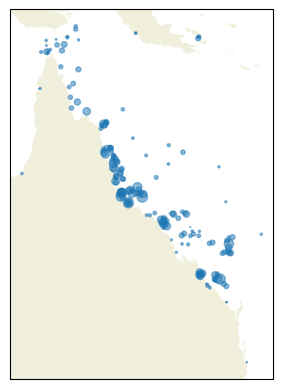

In [76]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree())
ax.scatter(counts.lon,counts.lat,s=counts.number/50000, alpha=0.5)
ax.add_feature(cf.LAND)

## Collect data in a specific region

The previous example filtered the data with a bounding box.
We will show here a more complex situation, extracting data about a specific region with a complex shape.

In [77]:
from shapely.geometry import Polygon

# Boundaries of the GBRMP zone MNP-18-1082 "South-east of Great Palm Island"
boundary = Polygon(
    [(146.551097906,-18.533297348),
    (146.995068388,-18.829679637),
    (146.995068388,-18.9503959749999),
    (146.741000438,-18.9503959749999),
    (146.726817846,-18.9503959749999),
    (146.726817846,-18.901664877),
    (146.559980192,-18.901664877),
    (146.559980192,-18.860043204),
    (146.559980192,-18.830003607),
    (146.559980192,-18.7916486789999),
    (146.699865007,-18.7916486789999),
    (146.699865007,-18.7975971989999),
    (146.725899924,-18.7975971989999),
    (146.725899924,-18.746824945),
    (146.725899924,-18.7468142619999),
    (146.725872512,-18.746799391),
    (146.587994956,-18.672003247),
    (146.587994956,-18.665847742),
    (146.508765289,-18.5543376589999),
    (146.508765289,-18.544419717),
    (146.508765289,-18.533297348),
    (146.551097906,-18.533297348)]
)

### Build a filter for the chosen region
Filtering using the shape directly would be possible, but very inefficient. 
It is better to filter the data using a bounding box first, and then intersect with the shape as a second pass.

In [78]:
# Get the bounding box of the polygon
minx,miny,maxx,maxy = boundary.bounds

# Build the filter
filter = [('lon', '>=', minx),
          ('lat', '>=', miny),
          ('lon', '<=', maxx),
          ('lat', '<=', maxy),
          ('qc_flag', '=', 1),  # Only data with quality control flag 1
          #('time', '>=', pd.Timestamp('2002-07-20', tz="UTC"))
          #('time', '<', pd.Timestamp('2002-07-20', tz="UTC"))
          ]

### Fetch subset with `pyarrow`

In [79]:
ds = pq.ParquetDataset("s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
                       filters=[filter])  # Could be a list of multiple filters for alternative conditions (OR)

table = ds.read(['fid','site','qc_val','geometry'])  # The columns we want to read
df = table.to_pandas()

df

,fid,site,qc_val,geometry
0,28085253,Orpheus Island,26.3531,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
1,28085252,Orpheus Island,26.3232,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
2,28085251,Orpheus Island,26.3034,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
3,28085250,Orpheus Island,26.2934,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
4,28085249,Orpheus Island,26.2636,b'\x01\x01\x00\x00\x00\x1e\x16jM\xf3Vb@=\n\xd7...
...,...,...,...,...
983715,44619517,Havannah Island,24.9381,b'\x01\x01\x00\x00\x00A\xf1c\xcc]Qb@)\\\x8f\xc...
983716,44619513,Havannah Island,24.9581,b'\x01\x01\x00\x00\x00A\xf1c\xcc]Qb@)\\\x8f\xc...
983717,44619520,Havannah Island,24.9281,b'\x01\x01\x00\x00\x00A\xf1c\xcc]Qb@)\\\x8f\xc...
983718,44619519,Havannah Island,24.9281,b'\x01\x01\x00\x00\x00A\xf1c\xcc]Qb@)\\\x8f\xc...


`geometry` is a shape encoded in WKB. We can decode it with geopandas and use it for spatial filtering.

In [80]:
geom = gpd.GeoSeries.from_wkb(df['geometry'])
gdf = gpd.GeoDataFrame(df, geometry=geom)
gdf

,fid,site,qc_val,geometry
0,28085253,Orpheus Island,26.3531,POINT (146.71720 -18.80250)
1,28085252,Orpheus Island,26.3232,POINT (146.71720 -18.80250)
2,28085251,Orpheus Island,26.3034,POINT (146.71720 -18.80250)
3,28085250,Orpheus Island,26.2934,POINT (146.71720 -18.80250)
4,28085249,Orpheus Island,26.2636,POINT (146.71720 -18.80250)
...,...,...,...,...
983715,44619517,Havannah Island,24.9381,POINT (146.54270 -18.84750)
983716,44619513,Havannah Island,24.9581,POINT (146.54270 -18.84750)
983717,44619520,Havannah Island,24.9281,POINT (146.54270 -18.84750)
983718,44619519,Havannah Island,24.9281,POINT (146.54270 -18.84750)


In [82]:
# Intersect with the required boundary
gdf = gdf[gdf['geometry'].within(boundary)]

gdf

,fid,site,qc_val,geometry
0,28085253,Orpheus Island,26.3531,POINT (146.71720 -18.80250)
1,28085252,Orpheus Island,26.3232,POINT (146.71720 -18.80250)
2,28085251,Orpheus Island,26.3034,POINT (146.71720 -18.80250)
3,28085250,Orpheus Island,26.2934,POINT (146.71720 -18.80250)
4,28085249,Orpheus Island,26.2636,POINT (146.71720 -18.80250)
...,...,...,...,...
50547,27760270,Orpheus Island,28.6604,POINT (146.71720 -18.80250)
50548,27760267,Orpheus Island,28.6902,POINT (146.71720 -18.80250)
50549,27762279,Orpheus Island,28.6703,POINT (146.71720 -18.80250)
50550,27760269,Orpheus Island,28.6703,POINT (146.71720 -18.80250)


### Fetch subset with `dask`

In [83]:
dask_geo_df = dask_geopandas.read_parquet(
    "s3://rimrep-data-public/091-aims-sst/test-50-64-spatialpart/", 
    filters = [filter], 
    columns = ['site','qc_val','geometry'],
    index = 'fid',
    storage_options = {"anon": True})  # no authentication needed for this s3 bucket

# Intersect with geometry
dask_geo_df = dask_geo_df[dask_geo_df['geometry'].within(boundary)]

# Do the computation!
gdf = dask_geo_df.compute()
gdf

,site,qc_val,geometry
fid,,,
28085253,Orpheus Island,26.3531,POINT (146.71720 -18.80250)
28085252,Orpheus Island,26.3232,POINT (146.71720 -18.80250)
28085251,Orpheus Island,26.3034,POINT (146.71720 -18.80250)
28085250,Orpheus Island,26.2934,POINT (146.71720 -18.80250)
28085249,Orpheus Island,26.2636,POINT (146.71720 -18.80250)
...,...,...,...
27760270,Orpheus Island,28.6604,POINT (146.71720 -18.80250)
27760267,Orpheus Island,28.6902,POINT (146.71720 -18.80250)
27762279,Orpheus Island,28.6703,POINT (146.71720 -18.80250)
